# Libraries

In [ ]:
import os

# go up one directory
os.chdir("..")

import pandas as pd 
import numpy as np
from tqdm import tqdm
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from functions.graph_tools import *
from models.nmf import *
from functions import cosmic_val
from functions import data_handling as dh

# set seed
np.random.seed(30)

# Data

In [2]:
data_path = "data/catalogues_Ovary_SBS.tsv"
cosmic_path = "data/COSMIC_v3.4_SBS_GRCh37.txt"
output_folder = "data/processed"
output_filename = "Ordered_Ovary_SBS.csv"
ordered_data_path = os.path.join(output_folder, output_filename)

In [3]:
dh.load_preprocess_data(data_path, cosmic_path, sep1 = "\t", sep2 = "\t", output_folder = output_folder, output_filename = output_filename)

Data already exists in  data/processed/Ordered_Ovary_SBS.csv


In [4]:
# load data
data = pd.read_csv(ordered_data_path, index_col = 0)
cosmic = pd.read_csv(cosmic_path, sep = "\t", index_col = 0)

In [5]:
LATENT_DIM = 4
TOLERANCE = 1e-4
MAX_ITERATIONS = 100_000_000
SPLIT = 0.8

In [6]:
losses_train = []
losses_test = []
signatures = []
iterations = 30


for i in tqdm(range(iterations)):


    # Extract train and test data
    train_data = data.sample(frac = SPLIT, axis = 1)
    test_data = data.drop(train_data.columns, axis = 1)
    
    # Applying NMF
    signatures_nmf, exposures_nmf, loss_nmf = nmf(catalog_matrix = train_data.to_numpy(),
                                                  num_sign = LATENT_DIM,
                                                  tol = TOLERANCE,
                                                  max_iter = MAX_ITERATIONS)
    

    # Refitting NMF (test data)

    losses_refit = refit_NMF(test_data.to_numpy(), signatures_nmf)
    losses_test.append(losses_refit[-1])

    # Calculating signatures and exposures for NMF
    diagonals_nmf = signatures_nmf.sum(axis=0)
    exposures_nmf = exposures_nmf.T @ np.diag(diagonals_nmf)
    signatures_nmf = (signatures_nmf) @ np.diag(1 / diagonals_nmf)
    
    losses_train.append(loss_nmf[-1])
    signatures.append(signatures_nmf)



100%|██████████| 30/30 [13:02<00:00, 26.10s/it]


In [7]:
print("Losses train: ", np.mean(losses_train))
print("Losses test: ", np.mean(losses_test))

Losses train:  15071.910138723391
Losses test:  110970.277433892


In [8]:
all_signatures = np.hstack(signatures)

In [18]:
print(all_signatures.shape)

(96, 120)


In [9]:
pam = KMedoids(n_clusters = LATENT_DIM, metric='cosine').fit(all_signatures.T)
labels = pam.labels_
medoid_indices = pam.medoid_indices_
consensus_signatures = all_signatures[:, medoid_indices]

In [10]:
matched_signatures, mean_similarity = cosmic_val.compute_match(consensus_signatures, cosmic, index = 0)

In [11]:
print(matched_signatures.head())
print("\nMean similarity of the matched signatures: ", mean_similarity)

   Extracted_0  True_0  Similarity_0
0            0   SBS44      0.852432
1            1  SBS40c      0.867563
2            2  SBS40a      0.725355
3            3  SBS10c      0.758456

Mean similarity of the matched signatures:  0.8009515028824168


In [12]:
all_matches = cosmic_val.compute_all_matches(all_signatures, cosmic, n_runs = 4)

In [13]:
all_matches

,True_0,Similarity_0,True_1,Similarity_1,True_2,Similarity_2,True_3,Similarity_3,True_4,Similarity_4,...,True_25,Similarity_25,True_26,Similarity_26,True_27,Similarity_27,True_28,Similarity_28,True_29,Similarity_29
0,SBS6,0.917434,SBS57,0.743908,SBS10c,0.715217,SBS10a,0.931656,SBS6,0.918581,...,SBS10c,0.728481,SBS10a,0.931483,SBS5,0.765900,SBS10a,0.931489,SBS44,0.829842
1,SBS40a,0.699474,SBS10a,0.932045,SBS40a,0.710776,SBS44,0.812310,SBS40c,0.786405,...,SBS10a,0.931558,SBS10c,0.714681,SBS6,0.916093,SBS44,0.841161,SBS40a,0.718962
2,SBS44,0.790687,SBS40a,0.705205,SBS44,0.845049,SBS10c,0.687562,SBS10c,0.751667,...,SBS3,0.773321,SBS3,0.758394,SBS40a,0.818306,SBS3,0.728409,SBS10c,0.664339
3,SBS10c,0.741087,SBS6,0.871293,SBS10a,0.931578,SBS40a,0.725355,SBS13,0.711948,...,SBS44,0.848570,SBS44,0.841722,SBS10a,0.927349,SBS10c,0.750654,SBS10a,0.931781


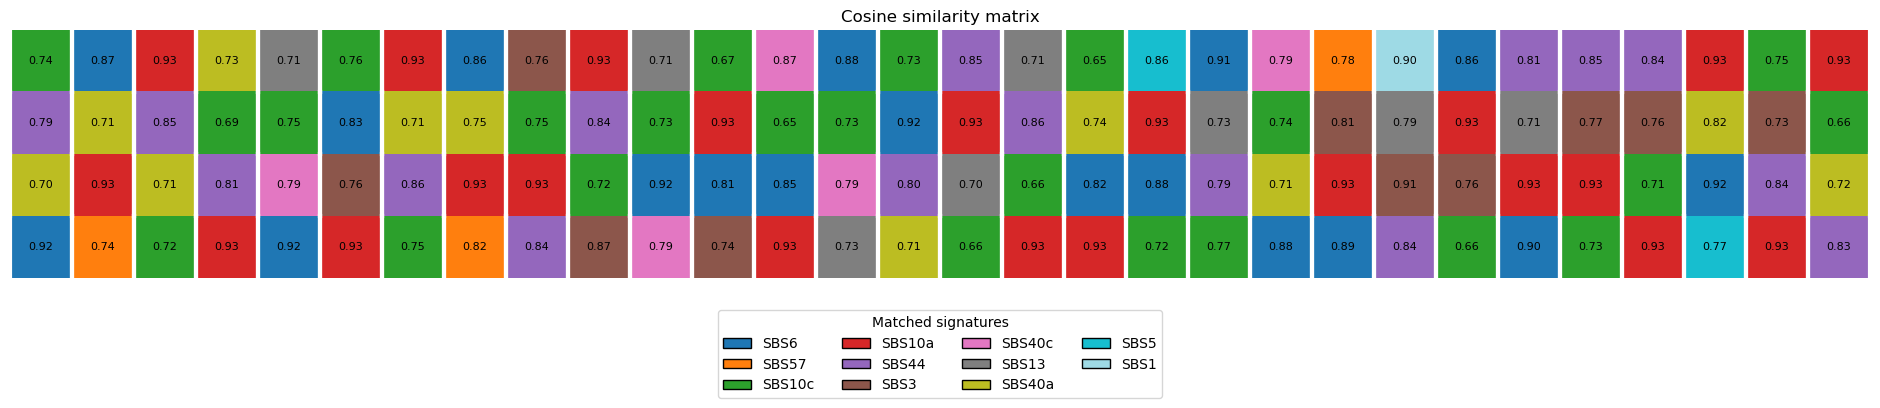

In [14]:
plot_cosine_similarity_matrix(all_matches, title = "Cosine similarity matrix", figsize=(24, 12), legend_colums=4, palette='tab20')

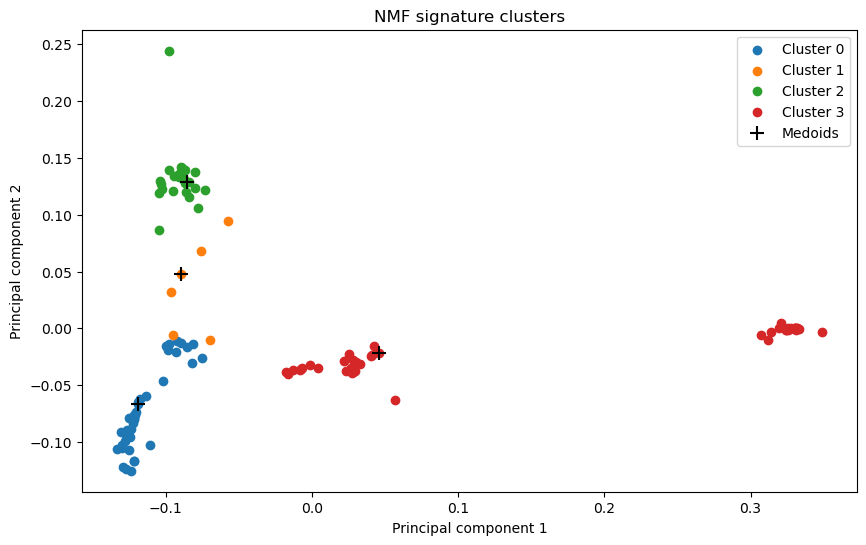

In [15]:
reduced_signatures = PCA(n_components=2).fit_transform(all_signatures.T)
plot_clusters(reduced_signatures, labels, medoid_indices, 4, "NMF signature clusters")

In [16]:
df_consensus = pd.DataFrame(consensus_signatures, index = data.index)

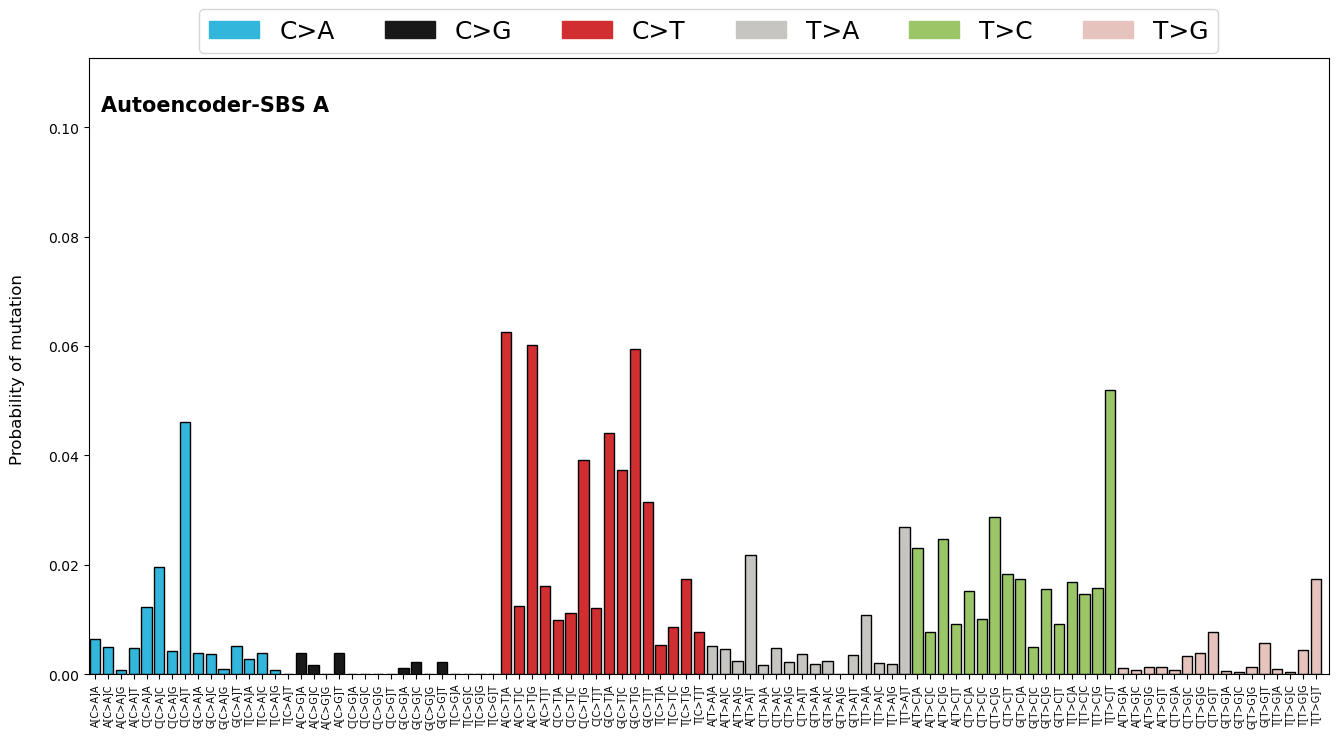

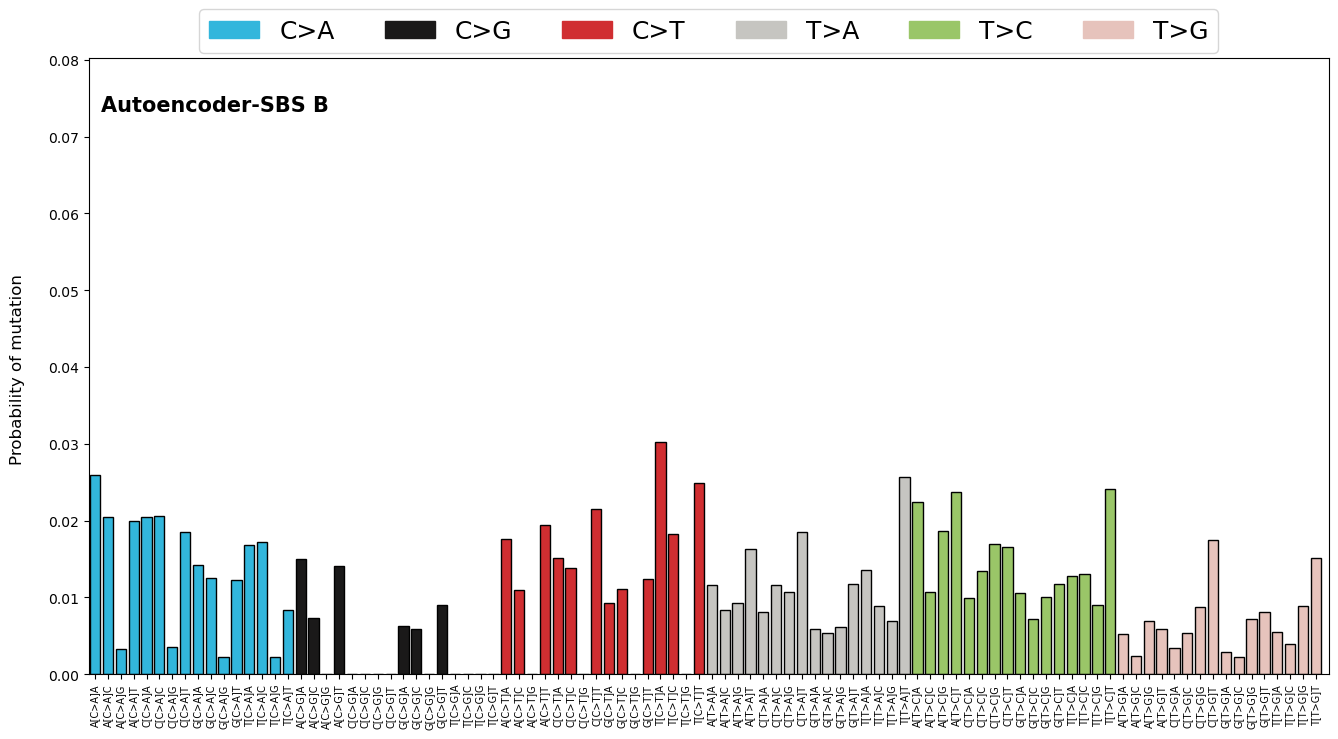

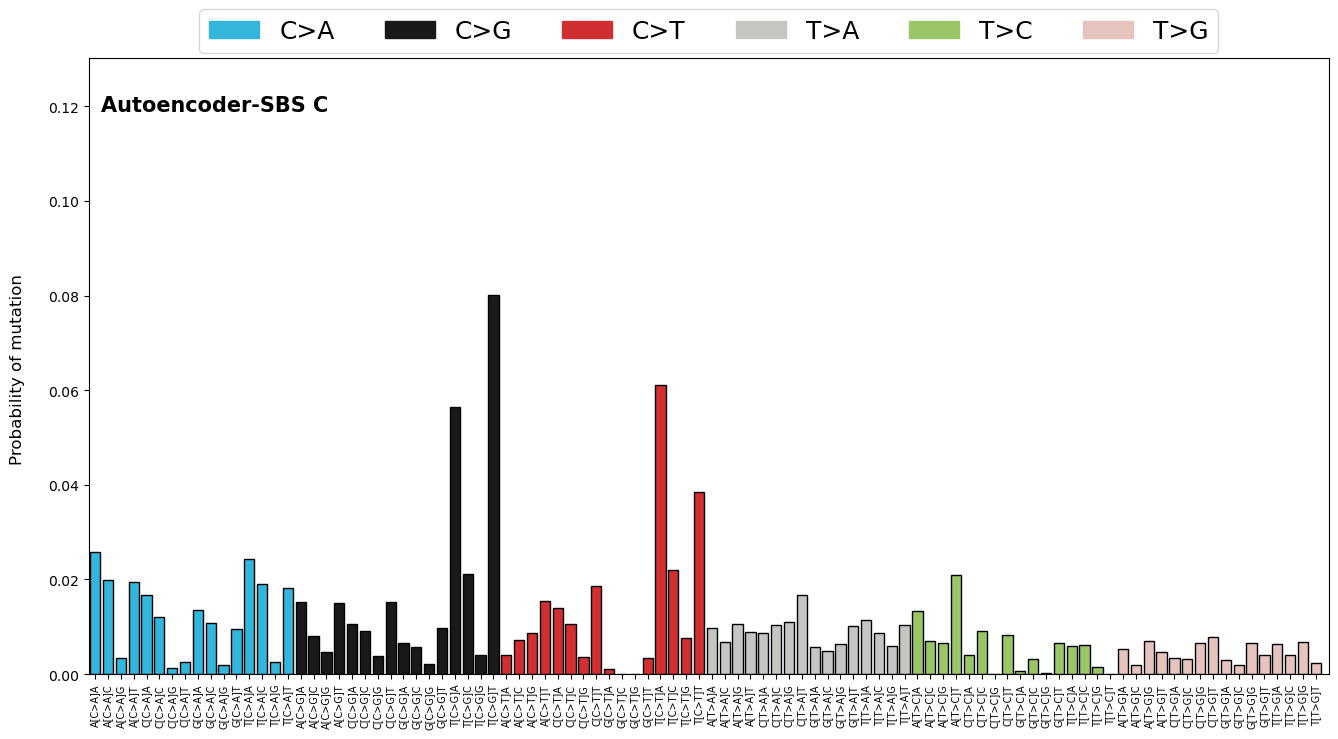

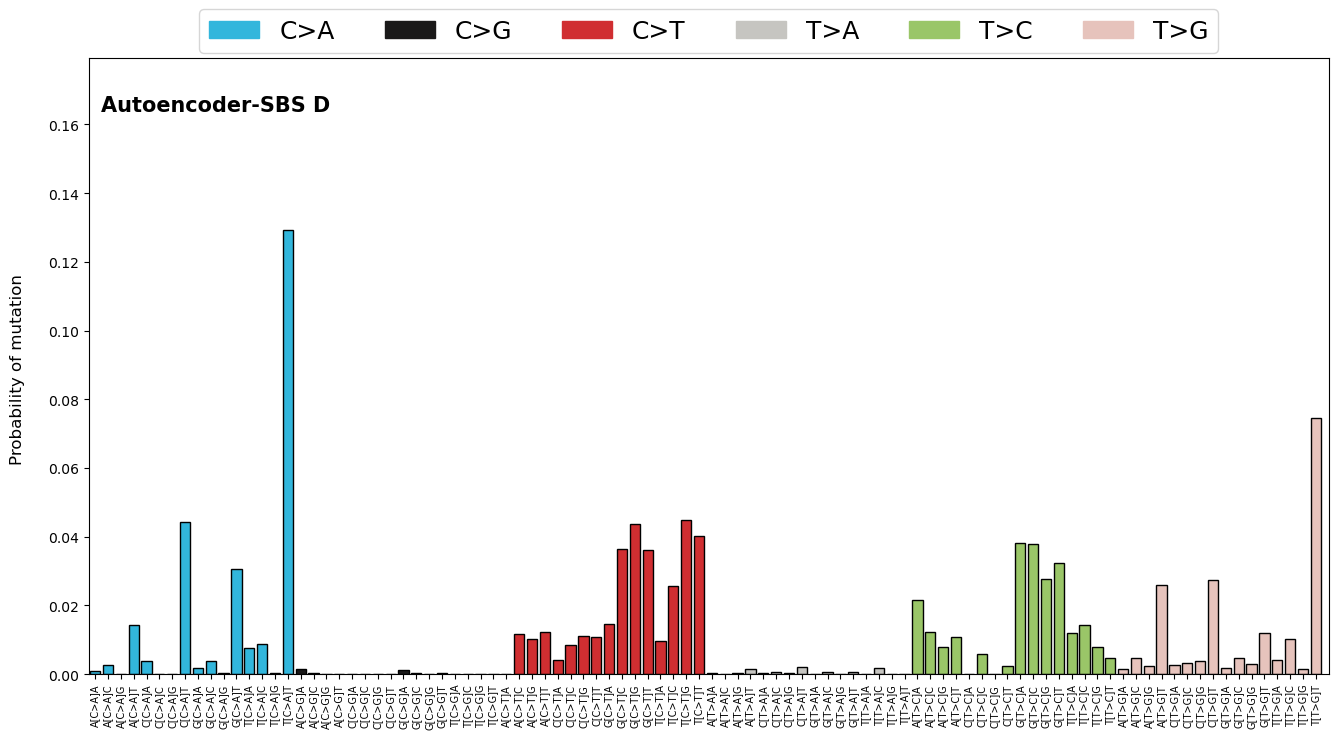

In [17]:
plot_signature(df_consensus)